# AG News Classification

## About the Data
### Origin
AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.

The AG's news topic classification dataset is constructed by Xiang Zhang from the dataset above. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).

### Description
The AG's news topic classification dataset is constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.

The file classes.txt contains a list of classes corresponding to each label.

The files train.csv and test.csv contain all the training samples as comma-sparated values. There are 3 columns in them, corresponding to class index (1 to 4), title and description. The title and description are escaped using double quotes ("), and any internal double quote is escaped by 2 double quotes (""). New lines are escaped by a backslash followed with an "n" character, that is "\n".

In [1]:
import pandas as pd
import numpy as np

import re
import string

import matplotlib.pyplot as plt

from termcolor import colored

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score
from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,GlobalMaxPooling1D,Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import plot_model

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
tf.random.set_seed(42)
tf.config.run_functions_eagerly(False)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nighthawks\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nighthawks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nighthawks\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load the dataset

In [2]:
TRAIN_FILE_PATH="./data/train.csv"
TEST_FILE_PATH='./data/test.csv'

train_data=pd.read_csv(TRAIN_FILE_PATH)
test_data=pd.read_csv(TEST_FILE_PATH)

train_data.columns = ['ClassIndex', 'Title', 'Description']
test_data.columns = ['ClassIndex', 'Title', 'Description']

X_train=train_data['Title']+" "+train_data['Description']
y_train=train_data['ClassIndex'].apply(lambda x:x-1)

X_test=test_data['Title']+ " "+test_data['Description']
y_test=test_data['ClassIndex'].apply(lambda x:x-1)

X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.2,random_state=42)

maxlen=X_train.map(lambda x:len(x.split())).max()
train_data.head()

labels = ['World News', 'Sports News', 'Business News', 'Science-Technology News']

raw_train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(10000).batch(32)
raw_val_ds=tf.data.Dataset.from_tensor_slices((X_val,y_val)).shuffle(10000).batch(32)
raw_test_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test)).shuffle(10000).batch(32)

In [3]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Title: ", text_batch.numpy()[i])
    print("Label: ", labels[label_batch.numpy()[i]])

Title:  b'Baltimore to quit stock market Baltimore Technologies, once a darling of the dotcom boom, is to quit the London stock market, putting an end to its chequered history as a listed company.'
Label:  Business News
Title:  b'Suspected Israeli Agents Kill Militant in Syria  DAMASCUS (Reuters) - Syria accused Israel of terrorism  after a bomb -- which Israeli security sources said Israel  planted -- killed a Hamas official in Damascus on Sunday. Hamas  vowed to retaliate.'
Label:  World News
Title:  b'Cardinal shakeup to cut jobs, improve profit Cardinal Health Inc. will cut 4,200 jobs, or 7 percent of its work force, as part of a three-year restructuring plan outlined Monday by the Central Ohio health-care products and services provider.'
Label:  Business News


In [4]:
raw_train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Prepare the dataset for training

In [5]:
def preprocess(X_batch,y_batch):
   # Convert to lowercase
   X_batch = tf.strings.lower(X_batch)

   # Remove HTML tags
   X_batch = tf.strings.regex_replace(X_batch, '<br />', ' ')

   # Remove punctuation
   X_batch = tf.strings.regex_replace(X_batch, '[%s]' % re.escape(string.punctuation), '')

   # Remove stopwords
   stop_words = stopwords.words('english')
   stop_words_regex = r'\b(' + r'|'.join(stop_words) + r')\b\s*'
   X_batch = tf.strings.regex_replace(X_batch, stop_words_regex, '')

    # Lemmatize
    
   # lemmatizer = WordNetLemmatizer()
   #  tokens = nltk.word_tokenize(x.decode('utf-8') for x in X_batch.numpy())
   #  tokens=nltk.word_tokenize(X_batch.decode('utf-8'))
   # tokenizer = tf.keras.preprocessing.text.Tokenizer()
   # tokenizer.fit_on_texts(x.decode('utf-8') for x in X_batch.numpy())
   # vocabulary_list = list(tokenizer.word_index.keys())
   # X_batch = ' '.join([lemmatizer.lemmatize(word) for word in vocabulary_list])

   X_batch=tf.strings.split(X_batch)
    
   return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [6]:
preprocess(text_batch,label_batch)

(<tf.Tensor: shape=(32, 56), dtype=string, numpy=
 array([[b'baltimore', b'quit', b'stock', ..., b'<pad>', b'<pad>',
         b'<pad>'],
        [b'suspected', b'israeli', b'agents', ..., b'<pad>', b'<pad>',
         b'<pad>'],
        [b'cardinal', b'shakeup', b'cut', ..., b'<pad>', b'<pad>',
         b'<pad>'],
        ...,
        [b'sharon', b'warns', b'snap', ..., b'shore', b'shattered',
         b'government'],
        [b'baseball', b'back', b'dc', ..., b'<pad>', b'<pad>', b'<pad>'],
        [b'red', b'sox', b'offer', ..., b'<pad>', b'<pad>', b'<pad>']],
       dtype=object)>,
 <tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([2, 0, 2, 3, 3, 3, 3, 0, 0, 2, 0, 1, 0, 2, 3, 3, 2, 2, 0, 0, 1, 3,
        1, 2, 3, 1, 3, 0, 1, 0, 1, 1], dtype=int64)>)

In [9]:
from collections import Counter
vocabulary=Counter()

for X_batch,y_batch in raw_train_ds.map(preprocess):
    for text in X_batch:
        vocabulary.update(list(text.numpy()))

In [10]:
vocabulary.most_common()[:10]

[(b'<pad>', 1672424),
 (b'39s', 24888),
 (b'new', 17015),
 (b'said', 15988),
 (b'us', 15511),
 (b'reuters', 13803),
 (b'ap', 12911),
 (b'first', 7176),
 (b'two', 7155),
 (b'world', 5969)]

In [11]:
len(vocabulary)

91422

In [13]:
vocab_size=20000
truncated_vocabulary=[
    word for word,count in vocabulary.most_common()[:vocab_size]
]

In [14]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"Iranian cleric upbeat on closure of nuclear case".split():
    print(word_to_id.get(word) or vocab_size)

20000
1096
3143
20000
5704
20000
189
281


In [15]:
words=tf.constant(truncated_vocabulary)
word_ids=tf.range(len(truncated_vocabulary),dtype=tf.int64)
vocab_init=tf.lookup.KeyValueTensorInitializer(words,word_ids)
num_oov_buckets=1000
table=tf.lookup.StaticVocabularyTable(vocab_init,num_oov_buckets)

In [16]:
table.lookup(tf.constant([b"Iranian cleric upbeat on closure of nuclear case".split()]))

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=
array([[20220,  1096,  3143, 20212,  5704, 20061,   189,   281]],
      dtype=int64)>

In [17]:
def encode_words(X_batch,y_batch):
    return table.lookup(X_batch),y_batch

In [22]:
train_ds=raw_train_ds.map(preprocess)
val_ds=raw_val_ds.map(preprocess)
test_ds=raw_test_ds.map(preprocess)

train_ds=train_ds.map(encode_words)
val_ds=val_ds.map(encode_words)
test_ds=test_ds.map(encode_words)


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
for X_batch, y_batch in train_ds.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[20452  3991   101 ...     0     0     0]
 [   72 12584   817 ...     0     0     0]
 [  575   318   426 ...     0     0     0]
 ...
 [ 1304 10821  7431 ...     0     0     0]
 [ 5953  1964 17766 ...     0     0     0]
 [  268  3527    86 ...     0     0     0]], shape=(32, 35), dtype=int64)
tf.Tensor([2 0 0 3 2 3 3 0 1 3 2 3 0 3 1 1 1 3 3 2 2 1 3 1 0 1 0 0 3 3 1 0], shape=(32,), dtype=int64)


In [24]:
embed_size=128
model=tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    tf.keras.layers.GRU(128,return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(4,activation='softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2688000   
                                                                 
 gru (GRU)                   (None, None, 128)         99072     
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 2,886,660
Trainable params: 2,886,660
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
callbacks=[
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-4,
        patience=4,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='weights2.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
]

In [27]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])


history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks)


Epoch 1/20
3000/3000 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8875
Epoch 1: val_accuracy improved from -inf to 0.91375, saving model to weights2.h5
3000/3000 [==============================] - 68s 20ms/step - loss: 0.3256 - accuracy: 0.8875 - val_loss: 0.2600 - val_accuracy: 0.9137
Epoch 2/20
3000/3000 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9372
Epoch 2: val_accuracy did not improve from 0.91375
3000/3000 [==============================] - 60s 20ms/step - loss: 0.1905 - accuracy: 0.9372 - val_loss: 0.2833 - val_accuracy: 0.9096
Epoch 3/20
2417/3000 [=======================>......] - ETA: 11s - loss: 0.1103 - accuracy: 0.9642

KeyboardInterrupt: 

In [28]:
model.load_weights('weights3.h5')
model.save('model3.hdf5')

In [29]:
loss,accuracy=model.evaluate(test_ds)
print("Loss: ",loss)
print("Accuracy: ",accuracy)

238/238 [==============================] - 2s 8ms/step - loss: 1.3861 - accuracy: 0.2570
Loss:  1.3860883712768555
Accuracy:  0.2569736838340759


In [30]:
history_dict = history.history
history_dict.keys()

NameError: name 'history' is not defined

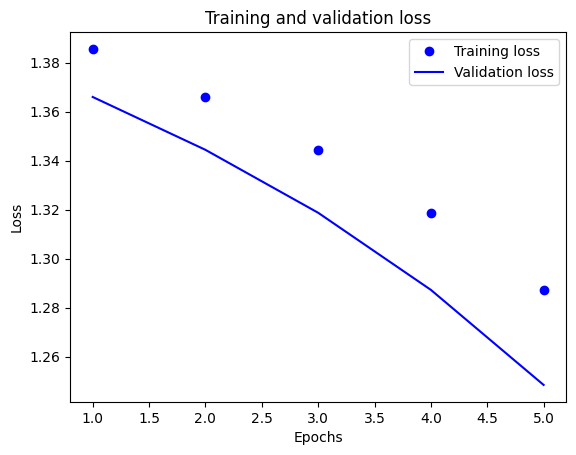

In [27]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

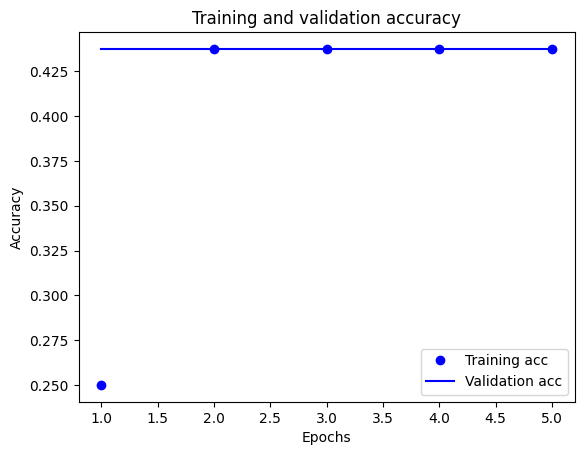

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()